# Introduction to SoS notebook

Script of Scripts (SoS) is a workflow engine that allows you to create and execute workflows that consist of scripts in different languages. You can use sos as a notebook tool to execute scripts interactively, or as a workflow tool to execute workflows in batch mode under different environments. This introduction demonstrates the first method of using SoS.

## Starting SoS notebook

If you have Python 3 (>=3.4.0) installed, installation of SoS can usually be done using command

```
% pip3 install sos
```
or

```
% pip install sos
```
depending on your system configuration. This command will also install Jupyter notebook and the SoS kernel for Jupyter.

After installation you can check if you have everything ready by running command

In [1]:
run:
   jupyter kernelspec list

Available kernels:
  python3    /Users/bpeng1/bin/anaconda/lib/python3.5/site-packages/ipykernel/resources
  ir         /Users/bpeng1/Library/Jupyter/kernels/ir
  sos        /usr/local/share/jupyter/kernels/sos


Here I am using SoS to run the shell command with a `run` action but you should see similar output if you enter the command from a terminal. If the command runs and outputs a kernel named `sos`, you can start Jupyter notebook using command

```
% jupyter notebook
```
and select `SoS` when you start a new notebook. Note that you will need to install the [IRkernel](https://github.com/IRkernel/IRkernel) if you would like to use R in SoS notebooks.

## Basic SoS

SoS is based on a slightly modified Python 3 syntax, with two syntax differences. The first one is that all single-triple quote strings are raw strings. That it to say, if you use `\n` in a triple-quote string, you will get the raw string as follows,

In [2]:
myscript = '''
this is my string with \n
'''
myscript

'\nthis is my string with \\n\n'

In comparison, if you define such a string in pure python, `\n` will be interpretted as newline.

In [3]:
python:
myscript = '''
this is my string with \n
'''
print(repr(myscript))

'\nthis is my string with \n\n'


Another difference is that SoS treats all strings as format string with string interpolation. Using the default sigil `${ }`, all variables and expressions between `${` and `}` will be evaluated and replaced with their values. The complete rules are defined in the [SoS documentation](https://github.com/BoPeng/SOS/wiki/Documentation#string-interpolation) but here are some examples:

In [4]:
resource   = '~/resources'
ref_genome = '${resource}/ref_genome/hg19'
samples    = ['sampleA', 'sampleB', 'sampleC']
print('There are ${len(samples)} samples with names ${samples!,}.')

There are 3 samples with names sampleA, sampleB, sampleC.


Here the variables are all stored in a SoS dictionary. You can print values of individual variables using 

In [5]:
ref_genome

'~/resources/ref_genome/hg19'

or using a SoS magic `%dict` to check the content of this dictionary.

In [6]:
%dict keys

{'glob', 'run_mode', 'step_name', 'SOS_SCRIPT', 'samples', '_index', 'SOS_VERSION', 'CONFIG', 'sys', 'os', 'resource', 'ref_genome'}

These are the variables that can be used in the notebook to, for example, compose scripts in other langauges. For example, you can call a shell command with variable `ref_genome`

In [9]:
run:
    echo ${ref_genome!e}

/Users/bpeng1/resources/ref_genome/hg19


Here we used variable `ref_genome` with convertion `e` (`os.path.expanduser`) to create a script and use `bash` to execute it.

## Using other languages


There are two ways to use other languages in SoS.

1. **Create scripts and use SoS to execute them** as you have seen for cells that start with `run:` and `python:`. This method requires the availability of the underlying interpreter (`bash`, `python`, `R` etc) but not corresponding Jupyter kernels. The scripts must be complete in this case.

2. **Start separate kernels using SoS magics `%with` and `%use` **. The `%with` magic allows you to execute a cell in a separate kernel, and `%use` magic allows you to switch to another kenel until you switch back. The scripts and commands will be executed in the kernels interactively and have access to variables in previous runs.

In [8]:
%with R
numbers = rnorm(5)
numbers

[1] -1.2451295  0.4199305  0.7507421  0.6768755 -0.4982190

SoS will switch back to the SoS kernel after the evaluation. It is also worth noting that the communication is one-directional in that whereas the scripts can be created using SoS variables, SoS does not collect any result from another kernel (to which SoS knows nothing). For example, the `numbers` variable in the IR kernel is unknown to SoS:

In [9]:
numbers

SoS workflow contains errors: default
[numbers ] NameError:
	name 'numbers' is not defined

Now, if you have a long script that you would like to debug line by line, you can switch to another kernel and switch back until you are done:

In [10]:
%use R

In [11]:
numbers

[1] -1.2451295  0.4199305  0.7507421  0.6768755 -0.4982190

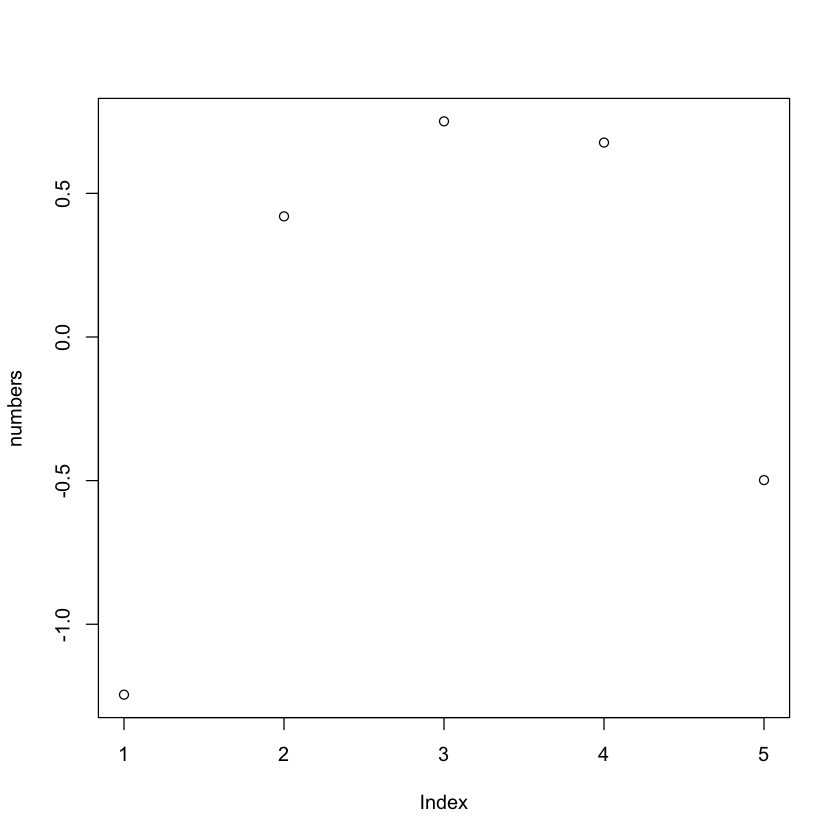

In [12]:
plot(numbers)

In [11]:
%use sos
# this magic switch the notebook back to SoS kernel

## SoS steps

Up till now your SoS steps consist only variable definitions and calling of scripts. There are a lot more that can be done. The most useful one is to define a list of output files. In this case SoS defines variables `output` and expect that you generate these files after the completion of the step. It will also generate previews for the output. 

In [12]:
output: 'test.jpg'
R:
    jpeg('${output}')
    plot(rnorm(100))
    dev.off()

You can also define `input` and can process multiple input files in groups.

In [15]:
input: '*.sos', group_by='single'
run:
    echo Processing  ${_input}

Processing example.sos
Processing rnaseq_tutorial.sos


INFO: Execute default_0: 
INFO: input:   ['example.sos', 'rnaseq_tutorial.sos']


input: example.sos , rnaseq_tutorial.sos 
output:

In [16]:
input:
run:
  echo Processing

Processing


INFO: Execute default_0: 
INFO: input:   []
